In [236]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid
from imblearn.over_sampling import RandomOverSampler
sns.set()

Загрузка данные сета.

In [237]:
glasses = pd.read_csv('glass.data', names=["Id", "Ri", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Class"])
#Смотрим основные параметры.

Оцениваем что в дата-сете есть, и с чем прийдется иметь дело.

In [238]:
glasses.head(100)

,Id,Ri,Na,Mg,Al,Si,K,Ca,Ba,Fe,Class
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.00,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.00,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.00,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.00,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...
95,96,1.51860,13.36,3.43,1.43,72.26,0.51,8.60,0.00,0.00,2
96,97,1.51841,13.02,3.62,1.06,72.34,0.64,9.13,0.00,0.15,2
97,98,1.51743,12.20,3.25,1.16,73.55,0.62,8.90,0.00,0.24,2
98,99,1.51689,12.67,2.88,1.71,73.21,0.73,8.54,0.00,0.00,2


In [239]:
glasses.drop(columns=["Id"], inplace=True)

Cмотрим насколько однородны данные и сколько пропущенных элементов в тех или иных столбцах.

In [240]:
glasses.count()

Ri       214
Na       214
Mg       214
Al       214
Si       214
K        214
Ca       214
Ba       214
Fe       214
Class    214
dtype: int64

В процентном соотношении.

In [241]:
for col in glasses.columns:
    pct_missing = np.mean(glasses[col].isnull())
    print(f'{col} - {round(pct_missing * 100, 5)}     min: {glasses[col].min()}     max:{glasses[col].max()}')

Ri - 0.0     min: 1.51115     max:1.53393
Na - 0.0     min: 10.73     max:17.38
Mg - 0.0     min: 0.0     max:4.49
Al - 0.0     min: 0.29     max:3.5
Si - 0.0     min: 69.81     max:75.41
K - 0.0     min: 0.0     max:6.21
Ca - 0.0     min: 5.43     max:16.19
Ba - 0.0     min: 0.0     max:3.15
Fe - 0.0     min: 0.0     max:0.51
Class - 0.0     min: 1     max:7


Видим дисбаланс классов, на 76 элементов класса "2" 9 элементов класса 6. Исправим используя алгоритм SMOTE

In [242]:
glasses["Class"].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Class, dtype: int64

In [243]:
target = glasses["Class"]
glasses.drop(columns=["Class"], inplace=True)
glasses, target = RandomOverSampler().fit_resample(glasses, target)
glasses.insert(9,"Class",target)

In [244]:
glasses["Class"].value_counts()

1    76
2    76
3    76
5    76
6    76
7    76
Name: Class, dtype: int64

Общие зависимости и распределение данных.

In [245]:
#sns.pairplot(glasses, hue="Class");

In [246]:
glasses.describe()

,Ri,Na,Mg,Al,Si,K,Ca,Ba,Fe,Class
count,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000
mean,1.518221,13.630987,2.070329,1.550241,72.678180,0.519035,9.176053,0.212588,0.046886,4.000000
std,0.002809,0.959598,1.578365,0.578869,0.880199,1.037251,1.409471,0.521845,0.100705,2.162619
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516550,13.000000,0.000000,1.230000,72.327500,0.000000,8.430000,0.000000,0.000000,2.000000
50%,1.517875,13.480000,2.410000,1.525000,72.760000,0.380000,8.820000,0.000000,0.000000,4.000000
75%,1.519690,14.190000,3.540000,1.800000,73.100000,0.580000,9.762500,0.000000,0.010000,6.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


Создаём карту корреляций.

<AxesSubplot: >

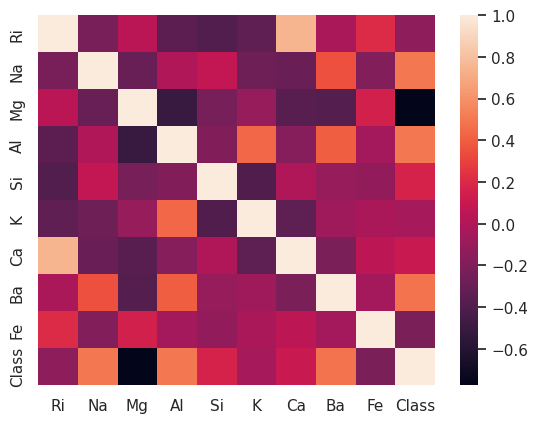

In [247]:
corr = glasses.corr()
sns.heatmap(corr)

Видно что столбцы Ca, K имеют корреляцию с другими параметрами но не с таргетом, можем их откинуть. Так же видно что корреляцию на таргет имеют столбцы Na, Al, Ba.

In [248]:
glasses.drop(columns=["Ca", "K"], inplace=True)

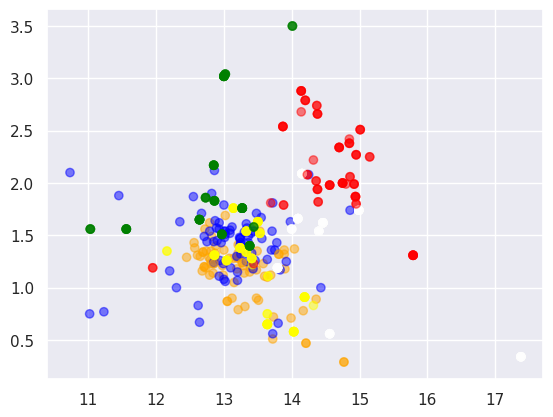

In [249]:
plt.scatter(glasses["Na"], glasses["Al"],alpha=0.5, c=glasses["Class"].map({1: "orange", 2: "blue",3:"yellow",4:"black",5:"green",6:"white",7:"red"}))

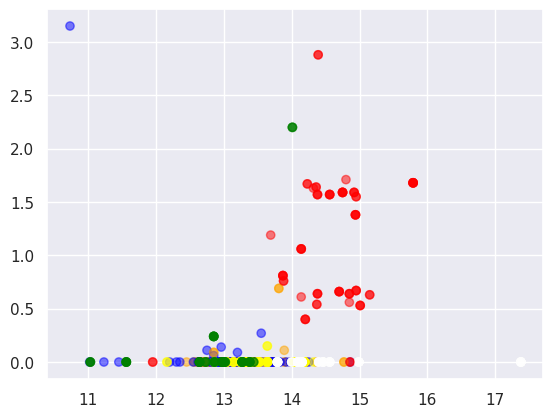

In [250]:
plt.scatter(glasses["Na"], glasses["Ba"],alpha=0.5, c=glasses["Class"].map({1: "orange", 2: "blue",3:"yellow",4:"black",5:"green",6:"white",7:"red"}))

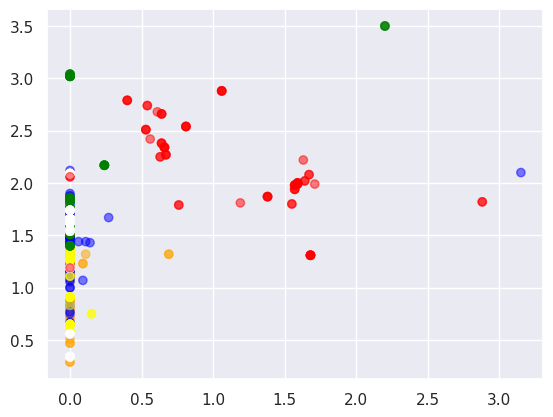

In [251]:
plt.scatter(glasses["Ba"], glasses["Al"],alpha=0.5, c=glasses["Class"].map({1: "orange", 2: "blue",3:"yellow",4:"black",5:"green",6:"white",7:"red"}))

По распределению сразу видно что по наличию бария сразу можно отделить 7 тип стеклянных изделий. Остальные в большинстве разделяются по наличию алюминия или натрия.

Выделяем столбец таргера

In [252]:
target = glasses["Class"]
glasses.drop(columns=["Class"], inplace=True)

Скалер и разделение даасета на train/test.

In [253]:
scaler = preprocessing.MinMaxScaler()
glasses = pd.DataFrame(scaler.fit_transform(glasses))

In [254]:
datasets = {"train": {}, "test": {}}
datasets["train"]["data"], datasets["test"]["data"], datasets["train"]["target"], datasets["test"][
    "target"] = train_test_split(glasses, target, train_size=0.833333333334, shuffle=True)
print(datasets["train"]["data"].shape)

(380, 7)


Смотрим что-бы все классы были распределены равномерно.

In [255]:
datasets["train"]["target"].value_counts()

2    68
3    67
1    64
5    63
6    60
7    58
Name: Class, dtype: int64

In [256]:
datasets["test"]["target"].value_counts()

7    18
6    16
5    13
1    12
3     9
2     8
Name: Class, dtype: int64

Тренеруем базовые модели.

In [257]:
knn = KNeighborsClassifier()
knn.fit(datasets["train"]["data"], datasets["train"]["target"])
rnc = RadiusNeighborsClassifier(radius=3)  #smallest possible radius
rnc.fit(datasets["train"]["data"], datasets["train"]["target"])
nearc = NearestCentroid()
nearc.fit(datasets["train"]["data"], datasets["train"]["target"])

NearestCentroid()

Сравним какая модель лучше себя покажет на валидационных данных, вычислив среднеквадратическую ошибку для каждой.

In [258]:
predictions = knn.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], predictions)
print("MSE for knn: {}".format(mse))

predictions = rnc.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], predictions)
print("MSE for rnc: {}".format(mse))

predictions = nearc.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], predictions)
print("MSE for nearc: {}".format(mse))

MSE for knn: 1.618421052631579
MSE for rnc: 11.105263157894736
MSE for nearc: 1.855263157894737


Как видно лучше всего справляется модель KNeighborsClassifier, её и возьмём за основу.

In [259]:
parameters = {"n_neighbors": (3, 4, 5, 6, 7, 8, 9), "weights": ("uniform", "distance"),
              "algorithm": ("ball_tree", "kd_tree", "brute"), "p": [1, 2]}
clf = GridSearchCV(KNeighborsClassifier(), parameters)
clf.fit(datasets["train"]["data"], datasets["train"]["target"])

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ('ball_tree', 'kd_tree', 'brute'),
                         'n_neighbors': (3, 4, 5, 6, 7, 8, 9), 'p': [1, 2],
                         'weights': ('uniform', 'distance')})

Получаем такой результат

In [260]:
prediction = clf.predict(datasets["test"]["data"])
mse = mean_squared_error(datasets["test"]["target"], prediction)
print("MSE: {}".format(mse))

MSE: 0.19736842105263158


Считаем метрики.

In [261]:
accuracy = metrics.accuracy_score(datasets["test"]["target"], prediction)
balanced_accuracy = metrics.balanced_accuracy_score(datasets["test"]["target"], prediction)
precision = metrics.precision_score(datasets["test"]["target"], prediction, average='weighted')
recall = metrics.recall_score(datasets["test"]["target"], prediction, average='weighted')

print("Presicion fo I_MF_model: ", round(precision, 2))
print("Recall fo I_MF_model: ", round(precision, 2))
print("Accurracy fo I_MF_model: ", round(accuracy, 2))
print("Balanced accurracy fo I_MF_model: ", round(balanced_accuracy, 2))

Presicion fo I_MF_model:  0.93
Recall fo I_MF_model:  0.93
Accurracy fo I_MF_model:  0.92
Balanced accurracy fo I_MF_model:  0.9


Смотрим не является ли наша модель константной.

In [262]:
pd.Series(prediction).value_counts()

7    18
6    16
3    13
5    13
1     9
2     7
dtype: int64

In [263]:
datasets["test"]["target"].value_counts()

7    18
6    16
5    13
1    12
3     9
2     8
Name: Class, dtype: int64

По полученным результатам видим что наша модель не является константной и может корректно разделять наши классы. Что видно по отличным показателям метриков и по малой ошибке.